<a href="https://colab.research.google.com/github/Falconwatch/SexInRussiaStudy/blob/main/SexInRussia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Чтение данных

In [1]:
!wget https://github.com/Falconwatch/SexInRussiaStudy/raw/main/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D0%BB%D0%B8_%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.xlsx

--2021-10-25 18:53:44--  https://github.com/Falconwatch/SexInRussiaStudy/raw/main/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D0%BB%D0%B8_%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.xlsx
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Falconwatch/SexInRussiaStudy/main/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D0%BB%D0%B8_%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.xlsx [following]
--2021-10-25 18:53:45--  https://raw.githubusercontent.com/Falconwatch/SexInRussiaStudy/main/%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F_%D0%B2_%D0%BF%D0%BE%D1%81%D1%82%D0%B5%D0%BB%D0%B8_%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.xlsx
Resolving raw.githubusercontent

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_excel("Россия_в_постели_открытые_данные.xlsx", skiprows=2)

In [4]:
data.head(2)

,Пол,Возраст,Ориентация,Текущий статус,Наличие детей,Регион,Контрацепция,Частота мастурбации,Частота секса,Наличие секс-игрушек,Возраст первого секса,Привлекающие части тела,Сексуальные предпочтения,Сексуальные практики,Оценка сексуальной жизни,Оценка реализации сексуальных предпочтений
0,Мужской,18-24,Гетеро,Свободен / свободна,Нету,Алтайский край,Презервативы,Раз в несколько дней,Другое (частота менялась на протяжении года),Нет,16,"Женская грудь, Попа / Ягодицы, Живот / Торс, Л...","Связывание, Долгая прелюдия, Мастурбация партн...","Мастурбация партнёру, Порка, Долгая прелюдия, ...",7.0,5.0
1,Женский,18-24,Гетеро,В отношениях,Нету,Алтайский край,Презервативы,Раз в неделю,Раз в неделю,Нет,16,"Половой член, Руки, Спина","Подчинение (по отношению к партнёру), На публи...","Нежный секс, Массаж, 69, Минет, Фистинг, Нижне...",7.0,3.0


# Основные данные

## Гендерный состав

Женский    23249
Мужской    10011
Name: Пол, dtype: int64

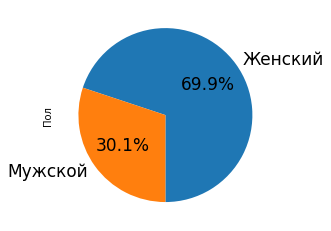

In [120]:
gender_stats = data["Пол"].value_counts()
total_women = gender_stats["Женский"]
total_men = gender_stats["Мужской"]

gender_stats[:2].plot(kind="pie", autopct='%1.1f%%', startangle=270, fontsize=17)
gender_stats[:2]

# Предобработка предпочтений и практик

In [99]:
#Список предпочтений
preferences = np.concatenate(data["Сексуальные предпочтения"].apply(lambda x: str(x).split(",")))
preferences = [p.lstrip().rstrip() for p in preferences]

#Считаем уникальные предпочтения и кладём в датафрейм
unique_values, unique_counts = np.unique(preferences, return_counts=True)
preferences_dataframe = pd.DataFrame(data = unique_values, columns = ["Предпочтение"])

preferences_dataframe["counts"] = unique_counts
preferences_dataframe.sort_values("counts", ascending=False, inplace=True)
preferences_dataframe.reset_index(inplace=True)
preferences_dataframe.drop(["index"], axis=1, inplace=True)

In [100]:
## Выделим самые популярные (или преставленные как варианты выбора)
##Криетрий популярности - более 0.1% человек

In [101]:
popular_preferences = preferences_dataframe[preferences_dataframe["counts"]>data.shape[0]/1000]

In [102]:
def normalize_preferences(prefs):
  result = list()
  prefs_splited = prefs.split(",")
  prefs_splited = [p.lstrip().rstrip() for p in prefs_splited]
  for one_pref in prefs_splited:
    if one_pref in popular_preferences["Предпочтение"].values:
      result.append(one_pref)
    else:
      result.append("Иное")
  result = np.unique(np.sort(np.array(result)))
  return result

In [103]:
data["prefs_array"] = data["Сексуальные предпочтения"].apply(lambda x: normalize_preferences(str(x)))
data["practices_array"] = data["Сексуальные практики"].apply(lambda x: normalize_preferences(str(x)))

In [104]:
#Предпочитаю, но не практикую
data["prefs_but_not_practice"] = data.apply(lambda x: list(set(x["prefs_array"]) - set(x["practices_array"])), axis=1)

#Практикую, но не хочу
data["practice_but_not_pref"] = data.apply(lambda x: list(set(x["practices_array"]) - set(x["prefs_array"])), axis=1)

# Анализ предпочтений и практик

## Не желаю, но практикую

In [105]:
from sklearn.preprocessing import MultiLabelBinarizer

In [106]:
mlb = MultiLabelBinarizer()
practice_but_not_pref_matrix = pd.DataFrame(data = mlb.fit_transform(data["practice_but_not_pref"]), columns = mlb.classes_)
prac_bnp = pd.concat([data, practice_but_not_pref_matrix], axis=1)

### Женщины

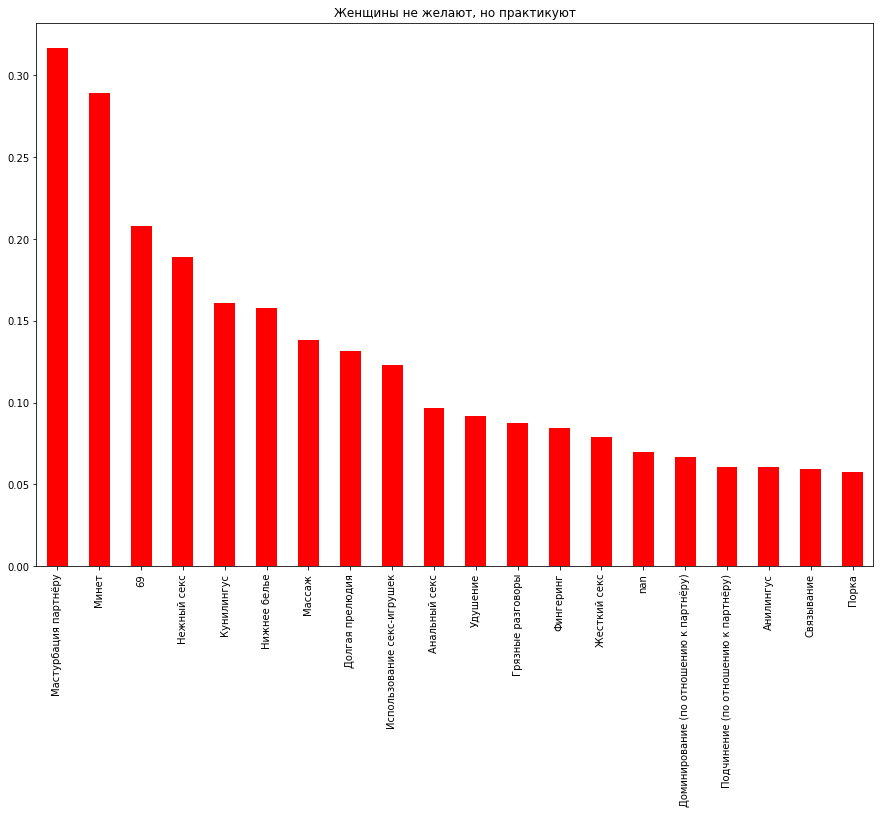

In [107]:
women_prac_bnp = prac_bnp.loc[prac_bnp["Пол"]=="Женский"][mlb.classes_].sum()/total_women
women_prac_bnp.sort_values(ascending=False, inplace=True)
women_prac_bnp[:20].plot(kind="bar", figsize=[15,10], title="Женщины не желают, но практикуют", color=["red"])

### Мужчины

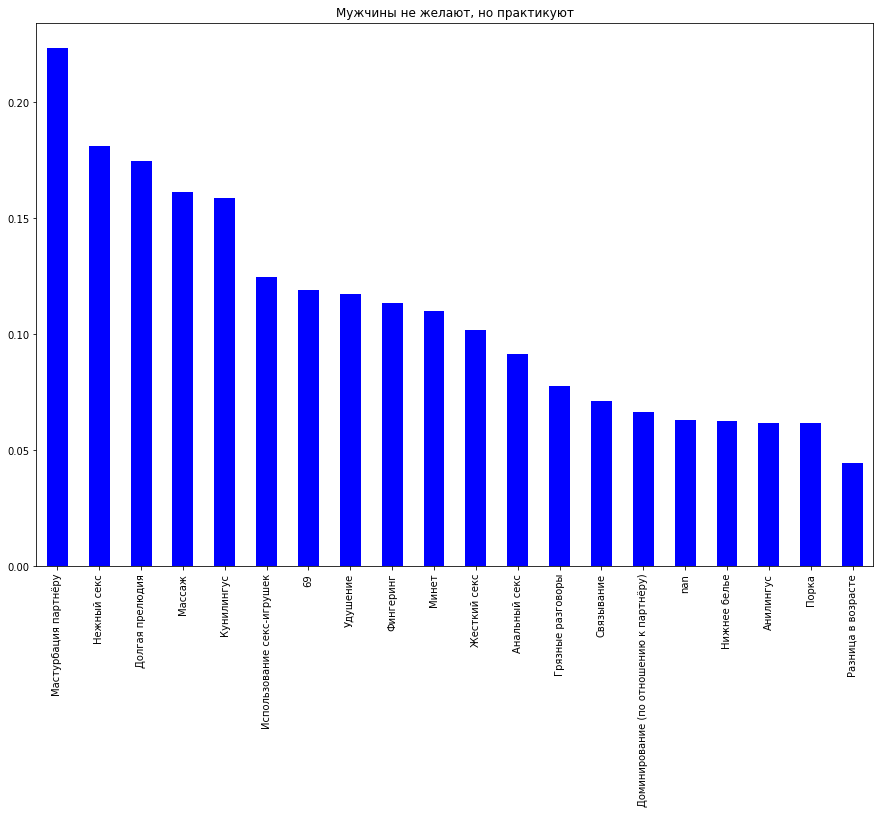

In [108]:
men_prac_bnp = prac_bnp.loc[prac_bnp["Пол"]=="Мужской"][mlb.classes_].sum()/total_men
men_prac_bnp.sort_values(ascending=False, inplace=True)
men_prac_bnp[:20].plot(kind="bar", figsize=[15,10], title="Мужчины не желают, но практикуют", color=["blue"])

### Совместно

In [109]:
men_prac_bnp.name="men"
women_prac_bnp.name="women"

together_prac_bnp = pd.merge(left=men_prac_bnp, right = women_prac_bnp, left_index=True, right_index=True)
together_prac_bnp["mean"] = together_prac_bnp.mean(axis=1)
together_prac_bnp["diff"] = abs(together_prac_bnp["men"] - together_prac_bnp["women"])

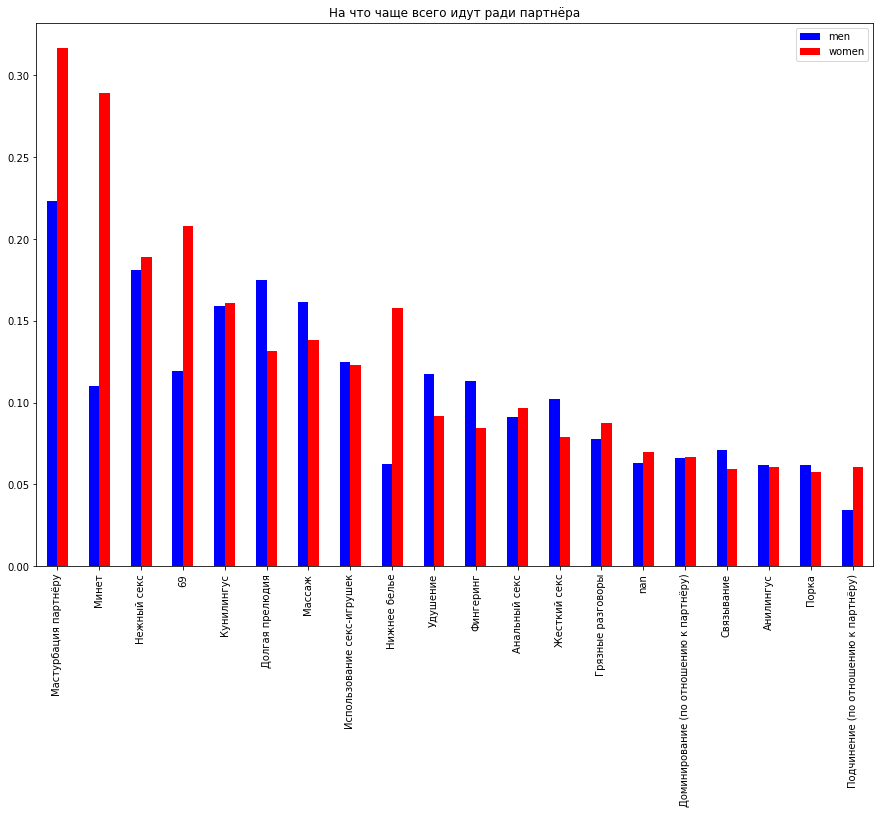

In [110]:
_ = together_prac_bnp.sort_values("mean", ascending=False)[["men", "women"]][:20]\
.plot(kind="bar", figsize=[15,10], title="На что чаще всего идут ради партнёра",
      color=["blue", "red"])

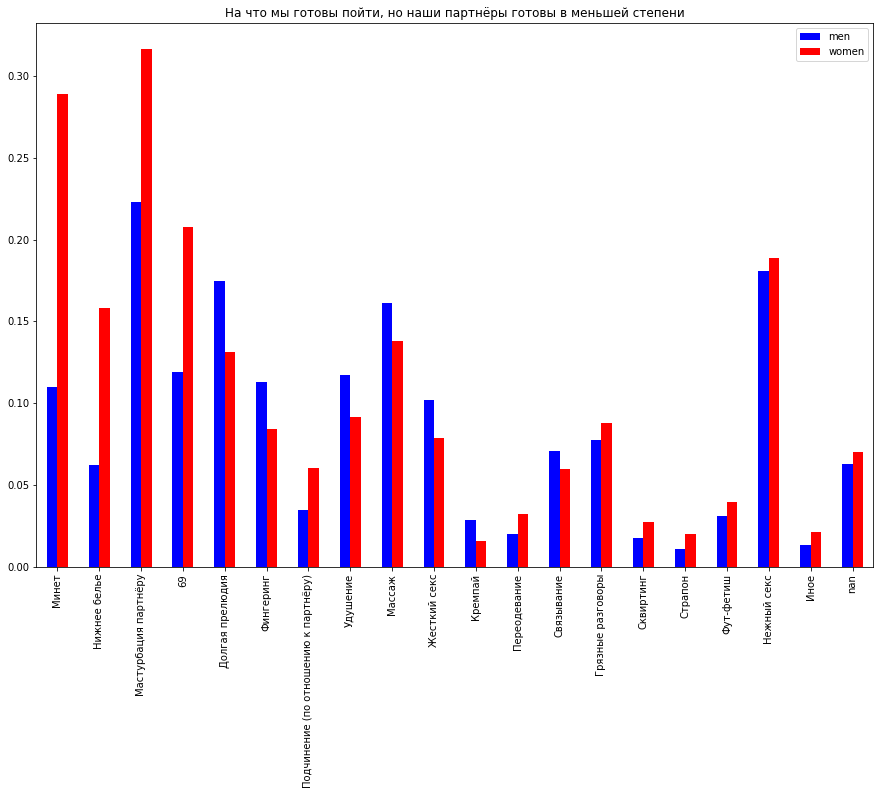

In [111]:
_ = together_prac_bnp.sort_values("diff", ascending=False)[["men", "women"]][:20]\
.plot(kind="bar", figsize=[15,10], title="На что мы готовы пойти, но наши партнёры готовы в меньшей степени",
      color=["blue", "red"])

## Желаю, но не получаю

In [112]:
mlb = MultiLabelBinarizer()
prefs_but_not_practice_matrix = pd.DataFrame(data = mlb.fit_transform(data["prefs_but_not_practice"]), columns = mlb.classes_)
pref_bnp = pd.concat([data, prefs_but_not_practice_matrix], axis=1)

### Женщины

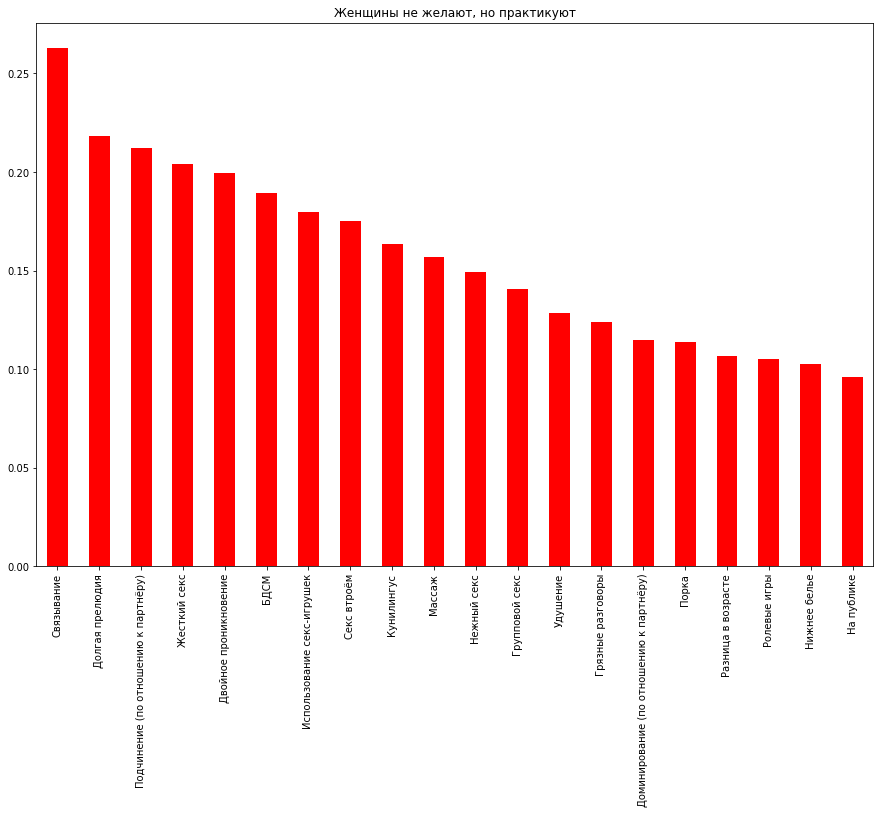

In [113]:
women_pref_bnp = pref_bnp.loc[pref_bnp["Пол"]=="Женский"][mlb.classes_].sum() / total_women
women_pref_bnp.sort_values(ascending=False, inplace=True)
women_pref_bnp[:20].plot(kind="bar", figsize=[15,10], title="Женщины не желают, но практикуют", color=["red"])

### Мужчины

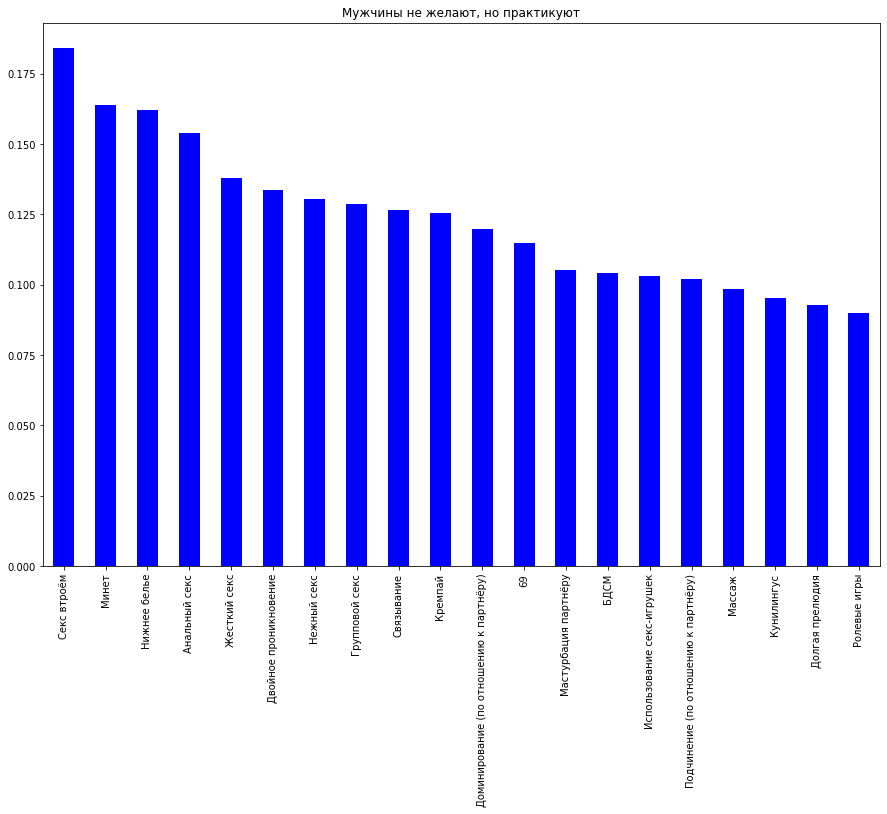

In [114]:
men_pref_bnp = pref_bnp.loc[pref_bnp["Пол"]=="Мужской"][mlb.classes_].sum() / total_men
men_pref_bnp.sort_values(ascending=False, inplace=True)
men_pref_bnp[:20].plot(kind="bar", figsize=[15,10], title="Мужчины не желают, но практикуют", color=["blue"])

### Совместно

In [115]:
men_pref_bnp.name="men"
women_pref_bnp.name="women"

together_pref_bnp = pd.merge(left=men_pref_bnp, right = women_pref_bnp, left_index=True, right_index=True)
together_pref_bnp["mean"] = together_pref_bnp.mean(axis=1)
together_pref_bnp["diff"] = abs(together_pref_bnp["men"] - together_pref_bnp["women"])

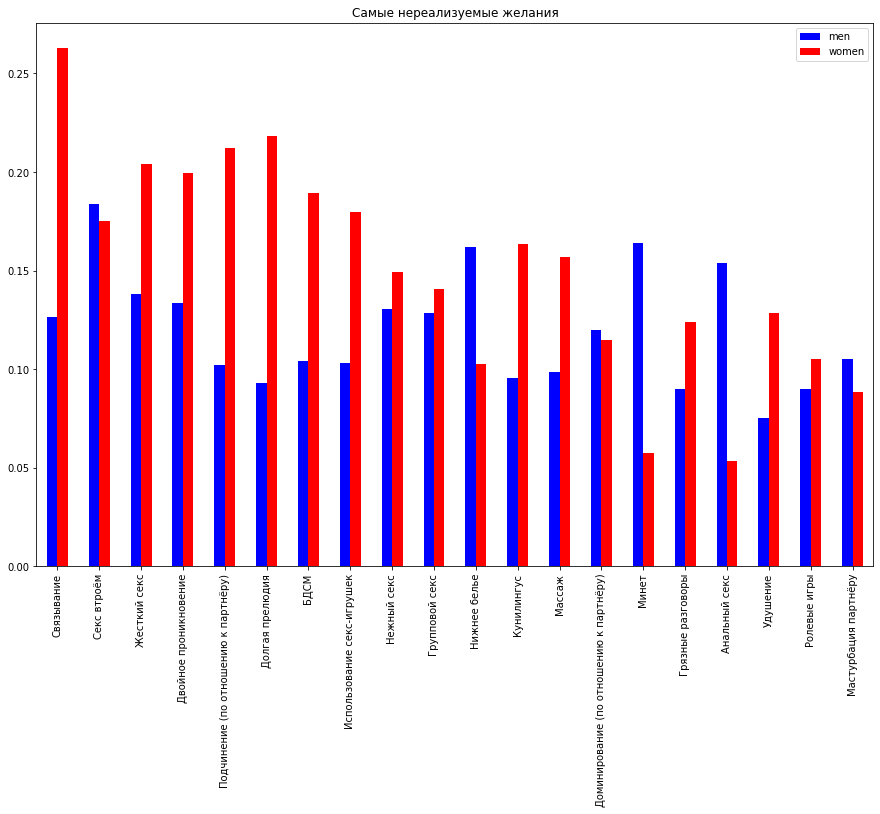

In [116]:
_ = together_pref_bnp.sort_values("mean", ascending=False)[["men", "women"]][:20]\
.plot(kind="bar", figsize=[15,10], title="Самые нереализуемые желания", 
      color=["blue", "red"])

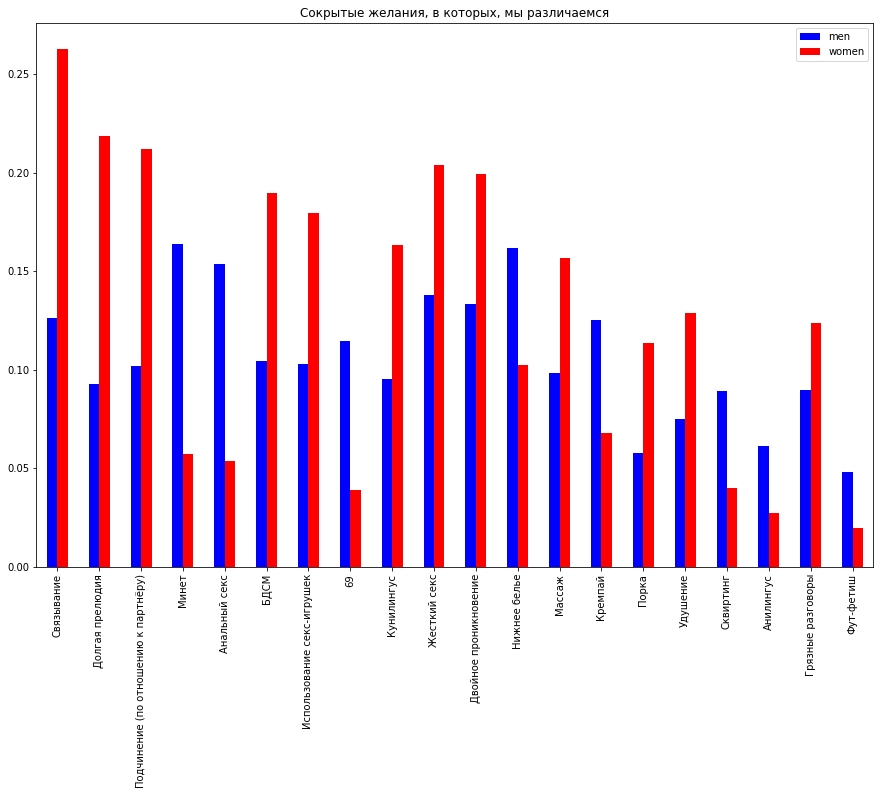

In [117]:
_ = together_pref_bnp.sort_values("diff", ascending=False)[["men", "women"]][:20]\
.plot(kind="bar", figsize=[15,10], title="Сокрытые желания, в которых, мы различаемся",
      color=["blue", "red"])